In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from MCS_Experiment import MCS
from MCS_Experiment import MCS_random_battery
from MCS_Experiment import MCS_grid_state
from MCS_Experiment import MCS_obstacle
from MCS_Experiment import MCS_less_reward
from MCS_Experiment import MCS_grid_state_less_reward
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

## DQN A

In [2]:
env = MCS()
env.get_state()

array([1., 0., 0., 1., 0., 0., 0., 0.])

In [26]:
env = MCS()
# env = MCS_random_battery()
# env = MCS_obstacle()

input_shape = [8]
n_outputs = 4

model_A = keras.models.Sequential([
    keras.layers.Dense(128, activation = 'relu', input_shape = input_shape),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(n_outputs)
])

In [27]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values = model_A.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [28]:
from collections import deque

replay_buffer = deque(maxlen = 2500)

In [29]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [30]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [31]:
batch_size = 500
discount_factor = 0.95
n_episodes = 500
max_steps = 10000
learning_rate = 0.00025
epsilon = 1

optimizer = keras.optimizers.Adam(lr=learning_rate)
loss_fn = keras.losses.mean_squared_error

In [32]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model_A.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones)*discount_factor*max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model_A(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model_A.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_A.trainable_variables))

In [33]:
rewards_A = []
timesteps_A = []
serviced_cars_A = []
serviced_cars_real_time_A = []
discharged_cars_A = []
routes_A = []
batteries_A = []
cus_batteries_A = []


for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    route = [env.grid]
    serviced_car_rt = [0]
    battery = [100]
    cus_battery = [env.cus_needs_battery]
    score = 0
    epsilon = max(0.01, epsilon*0.995)
    for step in range(max_steps):
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        score += reward
        route.append(env.grid.copy())
        serviced_car_rt.append(env.serviced_cars)
        battery.append(env.battery)
        cus_battery.append(env.cus_needs_battery)
        if done:
            break
    if len(replay_buffer) < 500:
        pass
    else:
        training_step(batch_size)
    rewards_A.append(score)
    timesteps_A.append(env.timesteps)
    serviced_cars_A.append(env.serviced_cars)
    serviced_cars_real_time_A.append(serviced_car_rt)
    discharged_cars_A.append(env.num_discharged_cars)
    routes_A.append(route)
    batteries_A.append(battery)
    cus_batteries_A.append(cus_battery)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [13:04<00:00,  1.57s/it]


In [ ]:
rewards_A.index(max(rewards_A))

Text(0, 0.5, 'reward')

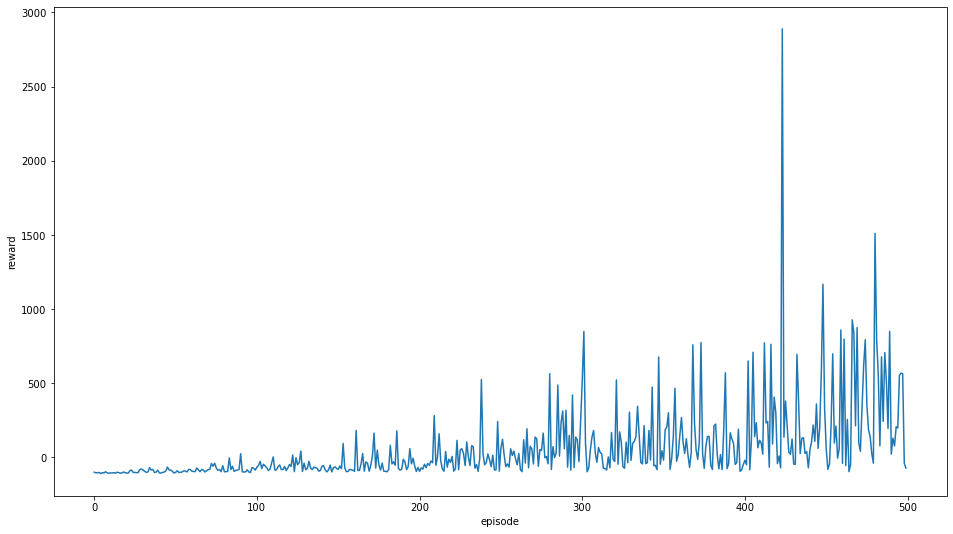

In [14]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(rewards_A_2)
ax.set_xlabel('episode')
ax.set_ylabel('reward')

Text(0, 0.5, 'serviced cars')

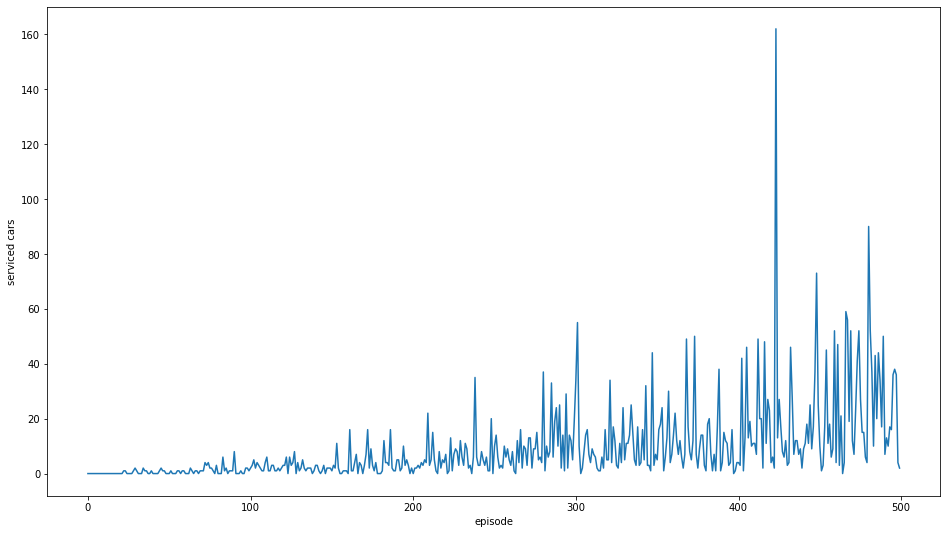

In [15]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(serviced_cars_A_2)
ax.set_xlabel('episode')
ax.set_ylabel('serviced cars')

In [19]:
exp_A_non = {'rewards':[], 'timesteps':[], 'serviced_cars':[], 'serviced_cars_real_time':[], 'discharged_cars':[], 'routes':[], 'batteries':[], 'cus_batteries': []}
obs = env.reset()
for step in range(500):
    action = np.argmax(model.predict(obs[np.newaxis]))
    obs, reward, done, info = env.step(action)
    exp_A_non['routes'].append(env.grid.copy())
#     exp_A_non['serviced_cars'].append(env.serviced_cars)
    exp_A_non['batteries'].append(env.battery)
    exp_A_non['cus_batteries'].append(env.cus_needs_battery)
    exp_A_non['serviced_cars_real_time'].append(env.serviced_cars)
        
    if done:
        break

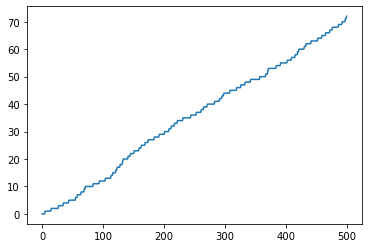

In [20]:
plt.plot(exp_A_non['serviced_cars_real_time'])

In [12]:
idx = serviced_cars.index(max(serviced_cars))

In [19]:
len(routes[idx])

2828

In [ ]:
target_cus = 100
game_count = 0

while target_cus:
    obs = env.reset()
    game_count += 1
    
    for step in range(10000):
        action = np.argmax(model.predict(obs[np.newaxis]))
        obs, reward, done, info = env.step(action)
        
        if done:
            break
        if env.serviced_cars >= 100:
            break
    target_cus -= env.serviced_cars
    target_cus = max(0,target_cus)

## Experiment C

In [10]:
# env = MCS()
env = MCS_grid_state()

input_shape = [10,10]
n_outputs = 4

model_C = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[10,10]),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(n_outputs)
])

In [11]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values = model_C.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [12]:
from collections import deque

replay_buffer = deque(maxlen = 2000)

In [13]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [14]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [15]:
batch_size = 500
discount_factor = 0.95
n_episodes = 500
max_steps = 10000
learning_rate = 0.00025
epsilon = 1

optimizer = keras.optimizers.Adam(lr=learning_rate)
loss_fn = keras.losses.mean_squared_error

In [16]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model_C.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones)*discount_factor*max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model_C(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model_C.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_C.trainable_variables))

In [17]:
rewards_C = []
timesteps_C = []
serviced_cars_C = []
serviced_cars_real_time_C = []
discharged_cars_C = []
routes_C = []
batteries_C = []
cus_batteries_C = []


for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    route = [env.grid]
    serviced_car_rt = [0]
    battery = [100]
    cus_battery = [env.cus_needs_battery]
    score = 0
    epsilon = max(0.01, epsilon*0.995)
    for step in range(max_steps):
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        score += reward
        route.append(env.grid.copy())
        serviced_car_rt.append(env.serviced_cars)
        battery.append(env.battery)
        cus_battery.append(env.cus_needs_battery)
        if done:
            break
    if len(replay_buffer) < 500:
        pass
    else:
        training_step(batch_size)
    rewards_C.append(score)
    timesteps_C.append(env.timesteps)
    serviced_cars_C.append(env.serviced_cars)
    serviced_cars_real_time_C.append(serviced_car_rt)
    discharged_cars_C.append(env.num_discharged_cars)
    routes_C.append(route)
    batteries_C.append(battery)
    cus_batteries_C.append(cus_battery)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:18<00:00,  3.61it/s]


## Experience B

In [34]:
env = MCS_less_reward()
# env = MCS_random_battery()
# env = MCS_obstacle()

input_shape = [8]
n_outputs = 4

model_B = keras.models.Sequential([
    keras.layers.Dense(128, activation = 'relu', input_shape = input_shape),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(n_outputs)
])

In [35]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values = model_B.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

from collections import deque

replay_buffer = deque(maxlen = 2500)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

batch_size = 500
discount_factor = 0.95
n_episodes = 500
max_steps = 10000
learning_rate = 0.00025
epsilon = 1

optimizer = keras.optimizers.Adam(lr=learning_rate)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model_B.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones)*discount_factor*max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model_B(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model_B.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_B.trainable_variables))

In [36]:
rewards_B = []
timesteps_B = []
serviced_cars_B = []
serviced_cars_real_time_B = []
discharged_cars_B = []
routes_B = []
batteries_B = []
cus_batteries_B = []


for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    route = [env.grid]
    serviced_car_rt = [0]
    battery = [100]
    cus_battery = [env.cus_needs_battery]
    score = 0
    epsilon = max(0.01, epsilon*0.995)
    for step in range(max_steps):
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        score += reward
        route.append(env.grid.copy())
        serviced_car_rt.append(env.serviced_cars)
        battery.append(env.battery)
        cus_battery.append(env.cus_needs_battery)
        if done:
            break
    if len(replay_buffer) < 500:
        pass
    else:
        training_step(batch_size)
    rewards_B.append(score)
    timesteps_B.append(env.timesteps)
    serviced_cars_B.append(env.serviced_cars)
    serviced_cars_real_time_B.append(serviced_car_rt)
    discharged_cars_B.append(env.num_discharged_cars)
    routes_B.append(route)
    batteries_B.append(battery)
    cus_batteries_B.append(cus_battery)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [11:19<00:00,  1.36s/it]


## Experiment D

In [21]:
# env = MCS()
env = MCS_grid_state_less_reward()

input_shape = [10,10]
n_outputs = 4

model_D = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[10,10]),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(n_outputs)
])

In [22]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values = model_D.predict(state[np.newaxis])
        return np.argmax(Q_values[0])
    
from collections import deque

replay_buffer = deque(maxlen = 2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

batch_size = 500
discount_factor = 0.95
n_episodes = 500
max_steps = 10000
learning_rate = 0.00025
epsilon = 1

optimizer = keras.optimizers.Adam(lr=learning_rate)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model_D.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones)*discount_factor*max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model_D(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model_D.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_D.trainable_variables))

In [23]:
rewards_D = []
timesteps_D = []
serviced_cars_D = []
serviced_cars_real_time_D = []
discharged_cars_D = []
routes_D = []
batteries_D = []
cus_batteries_D = []


for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    route = [env.grid]
    serviced_car_rt = [0]
    battery = [100]
    cus_battery = [env.cus_needs_battery]
    score = 0
    epsilon = max(0.01, epsilon*0.995)
    for step in range(max_steps):
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        score += reward
        route.append(env.grid.copy())
        serviced_car_rt.append(env.serviced_cars)
        battery.append(env.battery)
        cus_battery.append(env.cus_needs_battery)
        if done:
            break
    if len(replay_buffer) < 500:
        pass
    else:
        training_step(batch_size)
    rewards_D.append(score)
    timesteps_D.append(env.timesteps)
    serviced_cars_D.append(env.serviced_cars)
    serviced_cars_real_time_D.append(serviced_car_rt)
    discharged_cars_D.append(env.num_discharged_cars)
    routes_D.append(route)
    batteries_D.append(battery)
    cus_batteries_D.append(cus_battery)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:03<00:00,  2.73it/s]


## Graph

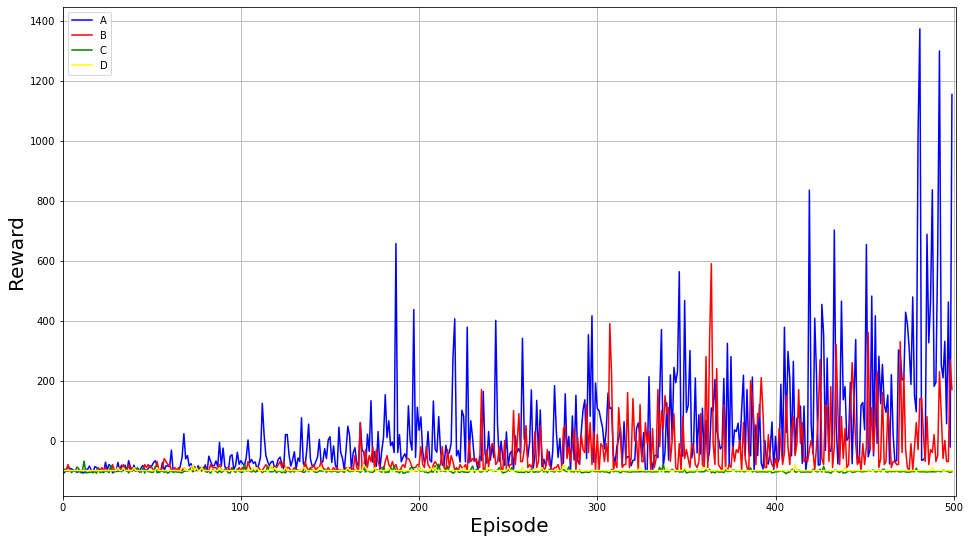

In [37]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(rewards_A, color='blue')
ax.plot(rewards_B, color='red')
ax.plot(rewards_C, color='green')
ax.plot(rewards_D, color='yellow')

ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Reward', fontsize=20)
ax.grid(True)
ax.set_xlim(0,501)
ax.legend(['A','B','C','D'])

In [40]:
cum_reward_A = []
cum_reward_B = []
cum_reward_C = []
cum_reward_D = []

In [44]:
for i in range(len(rewards_D)):
    if len(cum_reward_D) == 0:
        cum_reward_D.append(rewards_D[i])
    else:
        cum_reward_D.append(cum_reward_D[i-1] + rewards_D[i])

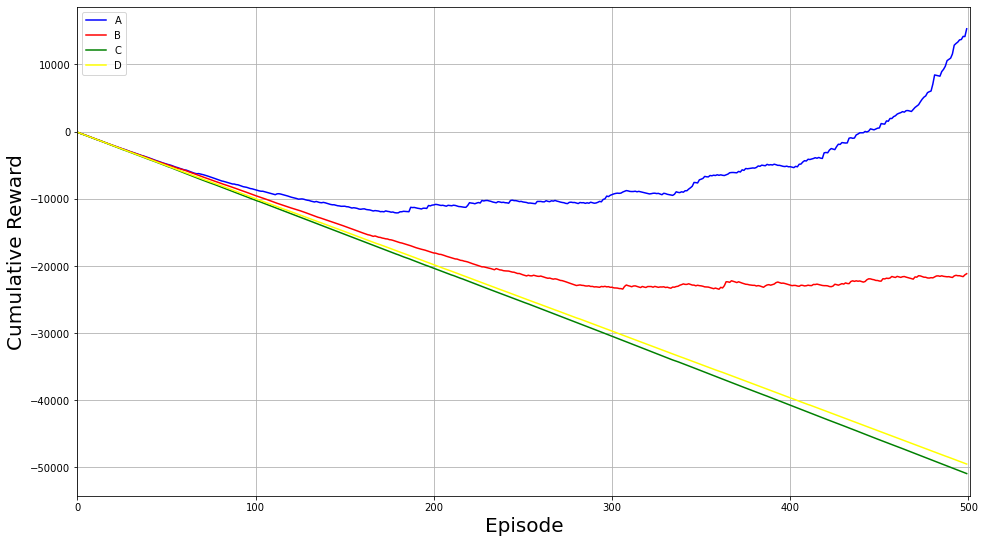

In [45]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(cum_reward_A, color='blue')
ax.plot(cum_reward_B, color='red')
ax.plot(cum_reward_C, color='green')
ax.plot(cum_reward_D, color='yellow')

ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Cumulative Reward', fontsize=20)
ax.grid(True)
ax.set_xlim(0,501)
ax.legend(['A','B','C','D'])

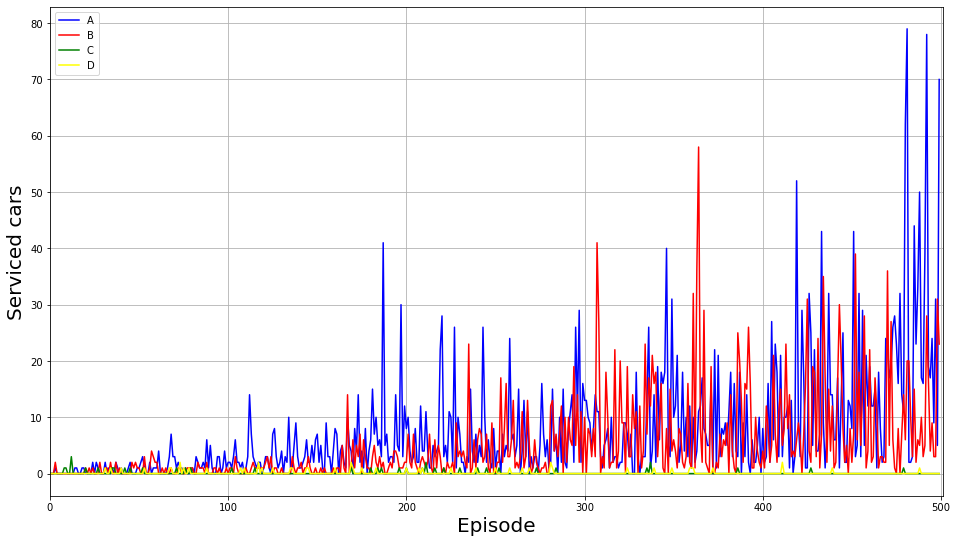

In [38]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(serviced_cars_A, color='blue')
ax.plot(serviced_cars_B, color='red')
ax.plot(serviced_cars_C, color='green')
ax.plot(serviced_cars_D, color='yellow')

ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Serviced cars', fontsize=20)
ax.grid(True)
ax.set_xlim(0,501)
ax.legend(['A','B','C','D'])

In [80]:
exp_A = {'rewards':[], 'timesteps':[], 'serviced_cars':[], 'serviced_cars_real_time':[], 'discharged_cars':[], 'routes':[], 'batteries':[], 'cus_batteries': []}
obs = env.reset()
for step in range(500):
    action = np.argmax(model.predict(obs[np.newaxis]))
    obs, reward, done, info = env.step(action)
    exp_A['routes'].append(env.grid.copy())
#     exp_A_non['serviced_cars'].append(env.serviced_cars)
    exp_A['batteries'].append(env.battery)
    exp_A['cus_batteries'].append(env.cus_needs_battery)
    exp_A['serviced_cars_real_time'].append(env.serviced_cars)
        
    if done:
        break

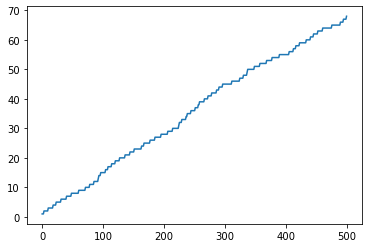

In [81]:
plt.plot(exp_A['serviced_cars_real_time'])

In [82]:
exp_A['serviced_cars_real_time'].index(10)

71

In [122]:
env = MCS()
exp_A_2 = {'rewards':[], 'timesteps':[], 'serviced_cars':[], 'serviced_cars_real_time':[], 'discharged_cars':[], 'routes':[], 'batteries':[], 'cus_batteries': []}
obs = env.reset()
for step in range(500):
    action = np.argmax(model_2.predict(obs[np.newaxis]))
    obs, reward, done, info = env.step(action)
    exp_A_2['routes'].append(env.grid.copy())
#     exp_A_non['serviced_cars'].append(env.serviced_cars)
    exp_A_2['batteries'].append(env.battery)
    exp_A_2['cus_batteries'].append(env.cus_needs_battery)
    exp_A_2['serviced_cars_real_time'].append(env.serviced_cars)
        
    if done:
        break

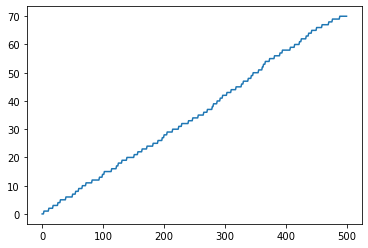

In [123]:
plt.plot(exp_A_2['serviced_cars_real_time'])

In [124]:
env = MCS_less_reward()
exp_B = {'rewards':[], 'timesteps':[], 'serviced_cars':[], 'serviced_cars_real_time':[], 'discharged_cars':[], 'routes':[], 'batteries':[], 'cus_batteries': []}
obs = env.reset()
for step in range(500):
    action = np.argmax(model_B.predict(obs[np.newaxis]))
    obs, reward, done, info = env.step(action)
    exp_B['routes'].append(env.grid.copy())
#     exp_A_non['serviced_cars'].append(env.serviced_cars)
    exp_B['batteries'].append(env.battery)
    exp_B['cus_batteries'].append(env.cus_needs_battery)
    exp_B['serviced_cars_real_time'].append(env.serviced_cars)
        
    if done:
        break

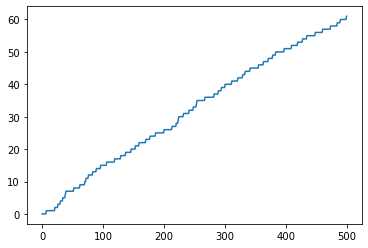

In [125]:
plt.plot(exp_B['serviced_cars_real_time'])

In [128]:
env = MCS_grid_state()
exp_C = {'rewards':[], 'timesteps':[], 'serviced_cars':[], 'serviced_cars_real_time':[], 'discharged_cars':[], 'routes':[], 'batteries':[], 'cus_batteries': []}
obs = env.reset()
for step in range(500):
    action = np.argmax(model_C.predict(obs[np.newaxis]))
    obs, reward, done, info = env.step(action)
    exp_C['routes'].append(env.grid.copy())
#     exp_A_non['serviced_cars'].append(env.serviced_cars)
    exp_C['batteries'].append(env.battery)
    exp_C['cus_batteries'].append(env.cus_needs_battery)
    exp_C['serviced_cars_real_time'].append(env.serviced_cars)
        
    if done:
        break

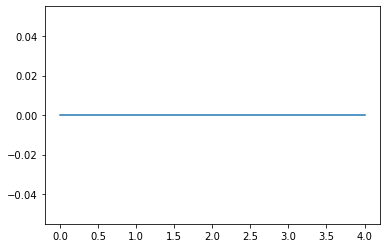

In [129]:
plt.plot(exp_C['serviced_cars_real_time'])

In [130]:
env = MCS_grid_state_less_reward()
exp_D = {'rewards':[], 'timesteps':[], 'serviced_cars':[], 'serviced_cars_real_time':[], 'discharged_cars':[], 'routes':[], 'batteries':[], 'cus_batteries': []}
obs = env.reset()
for step in range(500):
    action = np.argmax(model_D.predict(obs[np.newaxis]))
    obs, reward, done, info = env.step(action)
    exp_D['routes'].append(env.grid.copy())
#     exp_A_non['serviced_cars'].append(env.serviced_cars)
    exp_D['batteries'].append(env.battery)
    exp_D['cus_batteries'].append(env.cus_needs_battery)
    exp_D['serviced_cars_real_time'].append(env.serviced_cars)
        
    if done:
        break

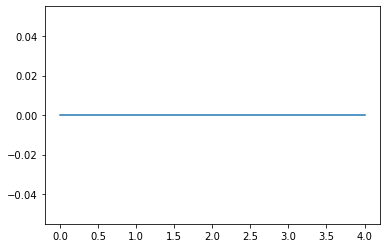

In [131]:
plt.plot(exp_D['serviced_cars_real_time'])

In [133]:
exp_D['serviced_cars_real_time']

[0, 0, 0, 0, 0]

In [101]:
exp_A_2['serviced_cars_real_time'].index(10)

66

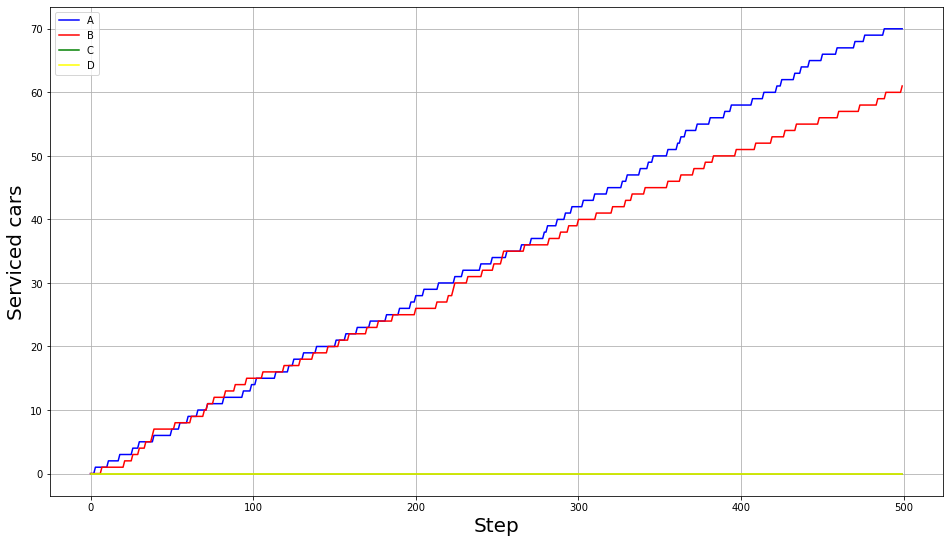

In [135]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

ax.plot(exp_A_2['serviced_cars_real_time'], color = 'blue')
ax.plot(exp_B['serviced_cars_real_time'], color = 'red')
ax.plot([0 for i in range(500)], color = 'green')
ax.plot([0 for i in range(500)], color = 'yellow')
ax.plot()
ax.set_xlabel('Step', fontsize=20)
ax.set_ylabel('Serviced cars', fontsize=20)
ax.grid(True)
ax.legend(['A', 'B', 'C', 'D'])


In [136]:
target_cus = 100
game_count = 0
env = MCS()
while target_cus:
    obs = env.reset()
    game_count += 1
    
    for step in range(10000):
        action = np.argmax(model_2.predict(obs[np.newaxis]))
        obs, reward, done, info = env.step(action)
        
        if done:
            break
        if env.serviced_cars >= 100:
            break
    target_cus -= env.serviced_cars
    target_cus = max(0,target_cus)

In [137]:
game_count

1

In [147]:
target_cus = 100
game_count = 0
env = MCS()
while target_cus:
    obs = env.reset()
    game_count += 1
    
    for step in range(500):
        action = np.argmax(model_3.predict(obs[np.newaxis]))
        obs, reward, done, info = env.step(action)
        
        if done:
            break
        if env.serviced_cars >= 100:
            break
    target_cus -= env.serviced_cars
    target_cus = max(0,target_cus)

In [148]:
game_count

24

## Experiment 추가

In [46]:
# env = MCS_less_reward()
env = MCS_random_battery()
# env = MCS_obstacle()

input_shape = [8]
n_outputs = 4

model_F = keras.models.Sequential([
    keras.layers.Dense(128, activation = 'relu', input_shape = input_shape),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(n_outputs)
])

In [47]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values = model_F.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

from collections import deque

replay_buffer = deque(maxlen = 2500)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

batch_size = 500
discount_factor = 0.95
n_episodes = 500
max_steps = 10000
learning_rate = 0.00025
epsilon = 1

optimizer = keras.optimizers.Adam(lr=learning_rate)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model_F.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones)*discount_factor*max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model_F(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model_F.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_F.trainable_variables))

In [48]:
rewards_F = []
timesteps_F = []
serviced_cars_F = []
serviced_cars_real_time_F = []
discharged_cars_F = []
routes_F = []
batteries_F = []
cus_batteries_F = []


for episode in tqdm(range(n_episodes)):
    obs = env.reset()
    route = [env.grid]
    serviced_car_rt = [0]
    battery = [100]
    cus_battery = [env.cus_needs_battery]
    score = 0
    epsilon = max(0.01, epsilon*0.995)
    for step in range(max_steps):
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        score += reward
        route.append(env.grid.copy())
        serviced_car_rt.append(env.serviced_cars)
        battery.append(env.battery)
        cus_battery.append(env.cus_needs_battery)
        if done:
            break
    if len(replay_buffer) < 500:
        pass
    else:
        training_step(batch_size)
    rewards_F.append(score)
    timesteps_F.append(env.timesteps)
    serviced_cars_F.append(env.serviced_cars)
    serviced_cars_real_time_F.append(serviced_car_rt)
    discharged_cars_F.append(env.num_discharged_cars)
    routes_F.append(route)
    batteries_F.append(battery)
    cus_batteries_F.append(cus_battery)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [14:12<00:00,  1.71s/it]


(0.0, 501.0)

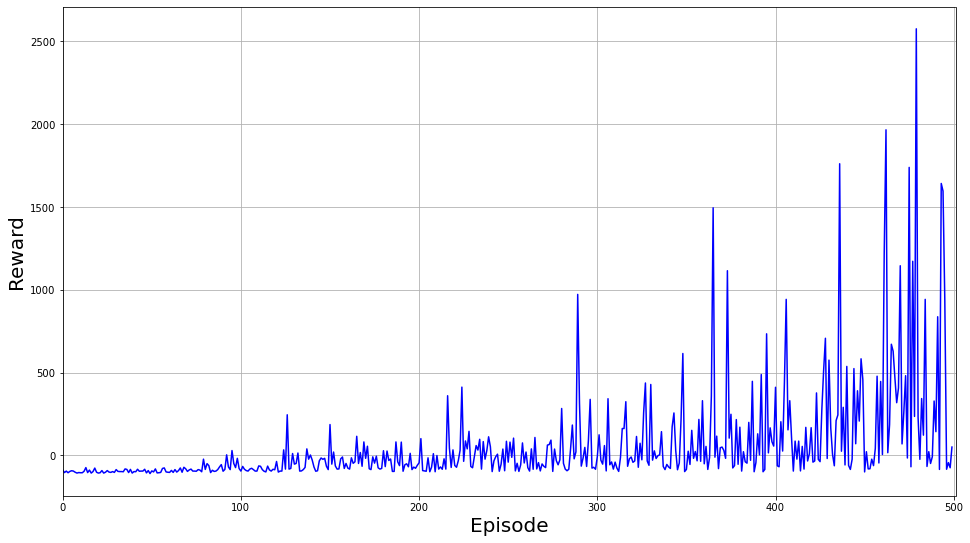

In [86]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(rewards_F, color='blue')


ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Reward', fontsize=20)
ax.grid(True)
ax.set_xlim(0,501)

(0.0, 501.0)

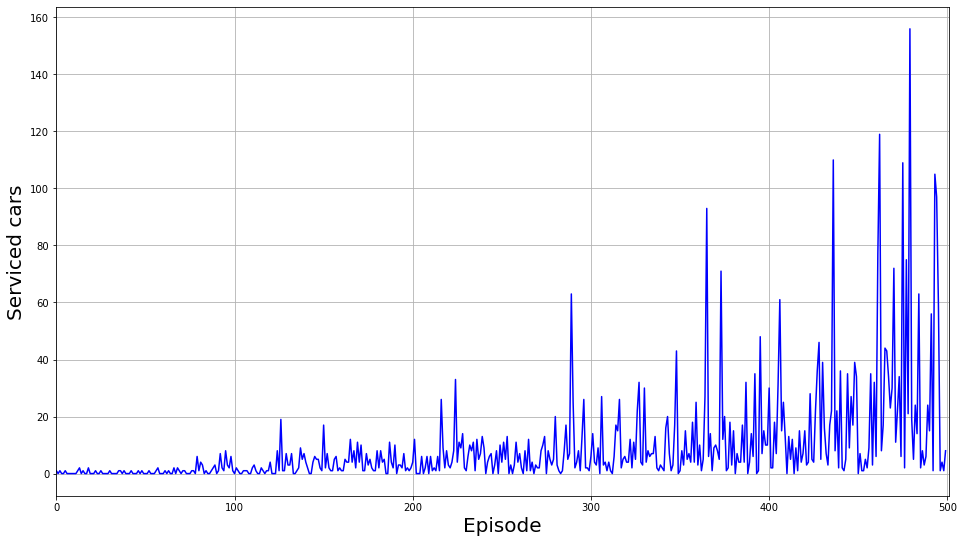

In [87]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(serviced_cars_F, color='blue')


ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Serviced cars', fontsize=20)
ax.grid(True)
ax.set_xlim(0,501)

In [49]:
cum_reward_F = []

In [51]:
for i in range(len(rewards_F)):
    if len(cum_reward_F) == 0:
        cum_reward_F.append(rewards_F[i])
    else:
        cum_reward_F.append(cum_reward_F[i-1] + rewards_F[i])

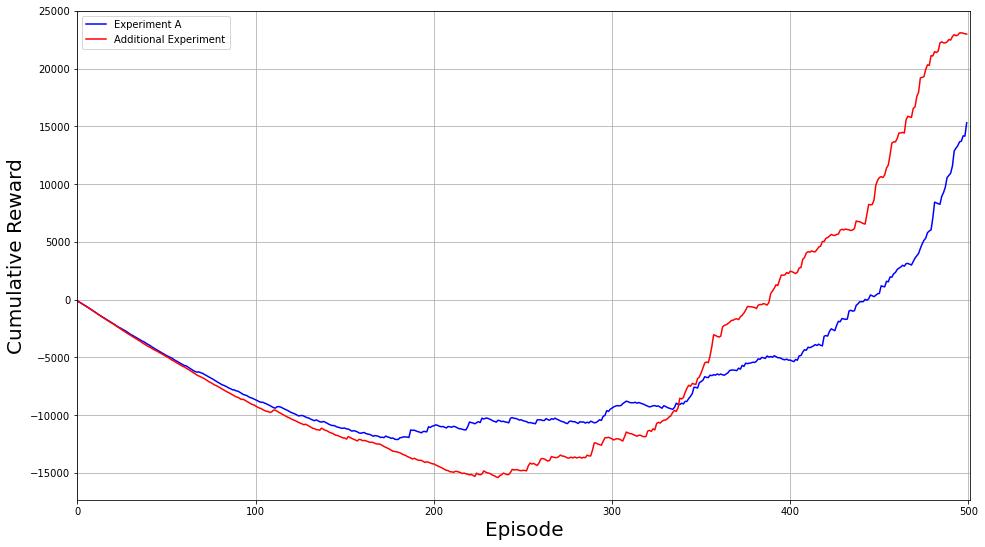

In [52]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(cum_reward_A, color='blue')
ax.plot(cum_reward_F, color='red')

ax.set_xlabel('Episode', fontsize=20)
ax.set_ylabel('Cumulative Reward', fontsize=20)
ax.grid(True)
ax.set_xlim(0,501)
ax.legend(['Experiment A','Additional Experiment'])

In [44]:
env = MCS()
exp_A = {'rewards':[], 'timesteps':[], 'serviced_cars':[], 'serviced_cars_real_time':[], 'discharged_cars':[], 'routes':[], 'batteries':[], 'cus_batteries': []}
obs = env.reset()
for step in range(500):
    action = np.argmax(model_2.predict(obs[np.newaxis]))
    obs, reward, done, info = env.step(action)
    exp_A['routes'].append(env.grid.copy())
#     exp_A_non['serviced_cars'].append(env.serviced_cars)
    exp_A['batteries'].append(env.battery)
    exp_A['cus_batteries'].append(env.cus_needs_battery)
    exp_A['serviced_cars_real_time'].append(env.serviced_cars)
        
    if done:
        break

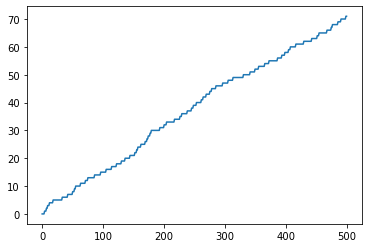

In [88]:
plt.plot(exp_A['serviced_cars_real_time'])

In [89]:
env = MCS_random_battery()
exp_F = {'rewards':[], 'timesteps':[], 'serviced_cars':[], 'serviced_cars_real_time':[], 'discharged_cars':[], 'routes':[], 'batteries':[], 'cus_batteries': []}
obs = env.reset()
for step in range(500):
    action = np.argmax(model.predict(obs[np.newaxis]))
    obs, reward, done, info = env.step(action)
    exp_F['routes'].append(env.grid.copy())
#     exp_A_non['serviced_cars'].append(env.serviced_cars)
    exp_F['batteries'].append(env.battery)
    exp_F['cus_batteries'].append(env.cus_needs_battery)
    exp_F['serviced_cars_real_time'].append(env.serviced_cars)
        
    if done:
        break

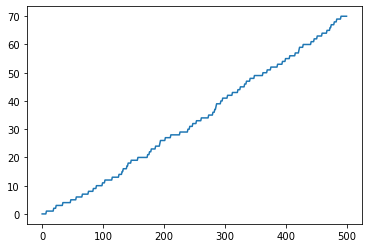

In [90]:
plt.plot(exp_F['serviced_cars_real_time'])

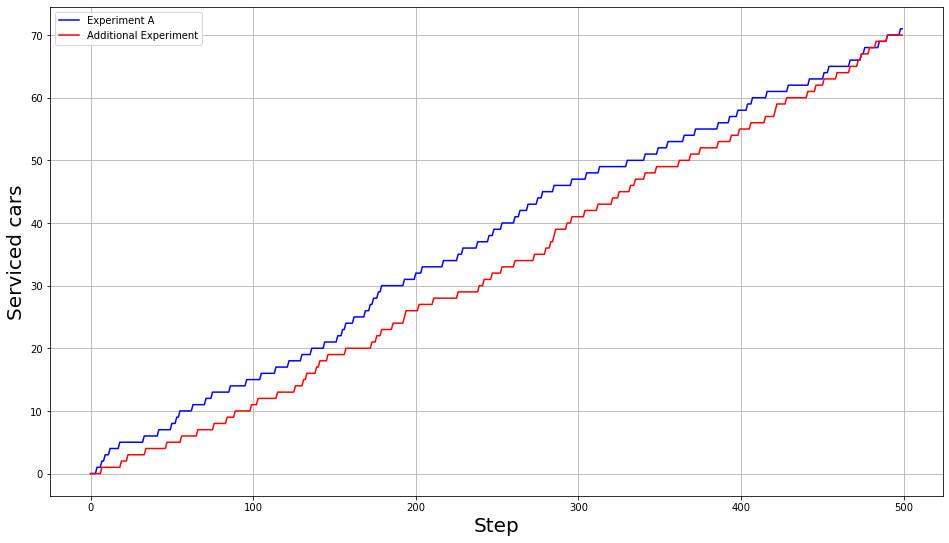

In [91]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)

ax.plot(exp_A['serviced_cars_real_time'], color = 'blue')
ax.plot(exp_F['serviced_cars_real_time'], color = 'red')
ax.set_xlabel('Step', fontsize=20)
ax.set_ylabel('Serviced cars', fontsize=20)
ax.grid(True)
ax.legend(['Experiment A', 'Additional Experiment'])

## Making Image

In [50]:
from celluloid import Camera
from matplotlib import gridspec

In [60]:
def make_image(idx, routes, serviced_cars_real_time, batteries, cus_batteries):
    fig = plt.figure(figsize=(18,9))
    gs = gridspec.GridSpec(nrows=2, ncols=4)
    ax = fig.add_subplot(gs[:,:2])
    ax2 = fig.add_subplot(gs[:,2])
    ax3 = fig.add_subplot(gs[:,3])
    route0 = routes[idx]         # --> 여기 index가 episode number
    
    camera = Camera(fig)
    steps = range(len(route0))
    count = serviced_cars_real_time[idx]    # --> 여기 index가 episode number
    sup_bat = batteries[idx]
    cus_bat = cus_batteries[idx]
    
    for i in steps:
        depot_row_loc = [None for i in range(10)]
        sup_row_loc = [None for i in range(10)]
        dem_row_loc = [None for i in range(10)]
        col_loc = range(10)
    
        depot = np.where(route0[i] == 3)
        sup = np.where(route0[i] == 1)
        dem = np.where(route0[i] == 2)
    
    
        if len(depot[0]) != 0:
            depot_row_loc[depot[0][0]] = 9 - depot[1][0]
            ax.scatter(col_loc, depot_row_loc, c='b',s=2000, marker='s')
        else:
            pass
        if len(dem[0]) != 0:
            dem_row_loc[dem[0][0]] = 9 - dem[1][0]
            ax.scatter(col_loc, dem_row_loc, c='g',s=2000, marker='s')
        else:
            pass
        if len(sup[0]) != 0:
            sup_row_loc[sup[0][0]] = 9 - sup[1][0]
            ax.scatter(col_loc, sup_row_loc, c='r',s=2000, marker='s')
        else:
            pass
    
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        ax.text(0.25, 1.01, 'Serviced cars: {0}'.format(count[i]), fontsize=30,transform=ax.transAxes)
    
        col = None
        if sup_bat[i] >= 50:
            col = 'lawngreen'
        elif sup_bat[i] > 20:
            col = 'orange'
        else:
            col = 'red'
        ax2.bar(' ', sup_bat[i],color=col)
        ax2.set_xlabel('Remain Supply Battery', fontsize=15)
        ax2.set_ylim(0,100)
    
        ax3.bar(' ', cus_bat[i], color='orange')
        ax3.set_xlabel('Demand Battery', fontsize=15)
        ax3.set_ylim(0,100)
    
        camera.snap()
    
    animation = camera.animate(interval=250,blit=True) 
    return animation

In [94]:
def make_image_obs(idx, routes, serviced_cars_real_time, batteries, cus_batteries):
    fig = plt.figure(figsize=(18,9))
    gs = gridspec.GridSpec(nrows=2, ncols=4)
    ax = fig.add_subplot(gs[:,:2])
    ax2 = fig.add_subplot(gs[:,2])
    ax3 = fig.add_subplot(gs[:,3])
    route0 = routes[idx]         # --> 여기 index가 episode number
    
    camera = Camera(fig)
    steps = range(len(route0))
    count = serviced_cars_real_time[idx]    # --> 여기 index가 episode number
    sup_bat = batteries[idx]
    cus_bat = cus_batteries[idx]
    
    for i in steps:
        depot_row_loc = [None for i in range(10)]
        sup_row_loc = [None for i in range(10)]
        dem_row_loc = [None for i in range(10)]
        obs_row_loc1 = [7,7,7,None,None,None,None,None,None,None]
        obs_row_loc2 = [None,None,2,2,2,None,None,None,None,None]
        obs_row_loc3 = [None,None,None,None,None,None,9,None,None,None]
        obs_row_loc4 = [None,None,None,None,None,None,8,None,None,None]
        col_loc = range(10)
    
        depot = np.where(route0[i] == 3)
        sup = np.where(route0[i] == 1)
        dem = np.where(route0[i] == 2)
        
        ax.scatter(col_loc, obs_row_loc1, c='black', s=2000, marker='s')
        ax.scatter(col_loc, obs_row_loc2, c='black', s=2000, marker='s')
        ax.scatter(col_loc, obs_row_loc3, c='black', s=2000, marker='s')
        ax.scatter(col_loc, obs_row_loc4, c='black', s=2000, marker='s')
        
    
        if len(depot[0]) != 0:
            depot_row_loc[depot[1][0]] = 9 - depot[0][0]
            ax.scatter(col_loc, depot_row_loc, c='b',s=2000, marker='s')
        else:
            pass
        if len(dem[0]) != 0:
            dem_row_loc[dem[1][0]] = 9 - dem[0][0]
            ax.scatter(col_loc, dem_row_loc, c='g',s=2000, marker='s')
        else:
            pass
        if len(sup[0]) != 0:
            sup_row_loc[sup[1][0]] = 9 - sup[0][0]
            ax.scatter(col_loc, sup_row_loc, c='r',s=2000, marker='s')
        else:
            pass
    
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        ax.text(0.25, 1.01, 'Serviced cars: {0}'.format(count[i]), fontsize=30,transform=ax.transAxes)
    
        col = None
        if sup_bat[i] >= 50:
            col = 'lawngreen'
        elif sup_bat[i] > 20:
            col = 'orange'
        else:
            col = 'red'
        ax2.bar(' ', sup_bat[i],color=col)
        ax2.set_xlabel('Remain Supply Battery', fontsize=15)
        ax2.set_ylim(0,100)
    
        ax3.bar(' ', cus_bat[i], color='orange')
        ax3.set_xlabel('Demand Battery', fontsize=15)
        ax3.set_ylim(0,100)
    
        camera.snap()
    
    animation = camera.animate(interval=250,blit=True) 
    return animation

In [85]:
serviced_cars_E.index(max(serviced_cars_E))

414

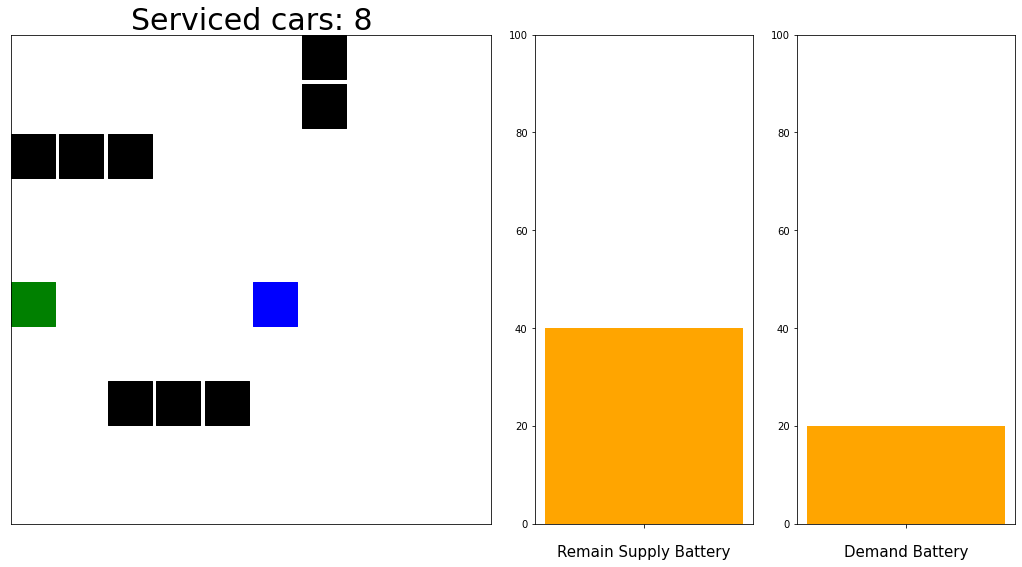

In [96]:
A = make_image_obs(414, routes_E, serviced_cars_real_time_E, batteries_E, cus_batteries_E)
A.save('E_max.gif',writer='pillow')

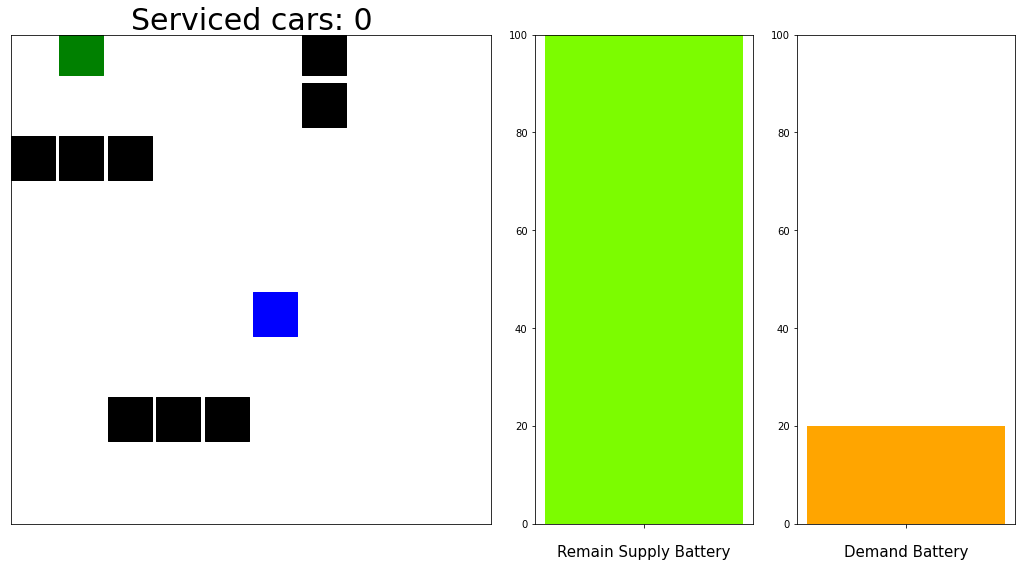

In [95]:
A = make_image_obs(2, routes_E, serviced_cars_real_time_E, batteries_E, cus_batteries_E)
A.save('E_untrained.gif',writer='pillow')

In [89]:
[2,0] in [[2,0],[2,1],[2,2],[0,6],[1,6],[7,2],[7,3],[7,4]]

True

In [93]:
np.where(routes_E[2][0] == 2)

(array([0], dtype=int64), array([1], dtype=int64))